#REVIEW - 3

Programme: CSE

Course Code: CSE3024

Course Name:  Web Mining


#Title: Fake News Prediction

Arnav Singh 20BCE1731

Archit Agarwal 20BCE1773

Deepansh Tripathi 20BCE1800


In this part of the project we will focus on the structure of the network, trying to identify some relevant metrics or properties on the users in order to differentiate the user more likely to share fake news. We will use the NetworkX package of python to realize the graph analysis.

## Importation of the needed packages

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import random
random.seed(1234)

import community
import itertools
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))



['data_competition']


## Importation of the datasets

For this part of the project we will build the graph of the relationships (followed/follower) betweens the users, so we need the * relation_user * data but we are also interested about the credibility of each user so we need the * newsUser *  and * labels_training * sets. 

In [ ]:
data_dir = '../input/data_competition/data_competition' 

relation_users = pd.read_csv(data_dir + "/UserUser.txt", sep="\t", header=None)
relation_users.columns = ["follower", "followed"]

labels_training = pd.read_csv(data_dir + "/labels_training.txt", sep=",")
labels_training.columns = ["news", "label"]

news_users = pd.read_csv(data_dir + "/newsUser.txt", sep="\t", header=None)
news_users.columns = ["news", "user", "times"]


In [ ]:
G = nx.DiGraph()

edges = [tuple(x) for x in relation_users.values]
G.add_edges_from(edges)

nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 23865\nNumber of edges: 574744\nAverage in degree:  24.0831\nAverage out degree:  24.0831'

Using the relations to build the edges we obtain a network of 23865 nodes and 574744 edges.

In [ ]:
n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()


## Identification of the fake news and real news sources and better understanding of the network

In this part we build for each user a score corresponding to the proportion of shared fake news on the training set. We are able to build this score for 18941 users ( the others did not share any news from the training set) and 14695 shared at least one fake new. A remark we can already make here is that it seems that most of the users shared really few news (mainly one), so we cannot consider them like an important user who shares a lot of fake news. 

In [ ]:
news_user_lab = pd.merge(news_users, labels_training, on='news')

user_sum_lab = news_user_lab[['user', 'label','times']].groupby(['user', 'label'])['times'].sum().reset_index()
user_sum_lab.sort_values(['times'], ascending=[False])

user_tot = news_users[['user', 'times']].groupby(['user'])['times'].sum().reset_index()
user_tot.set_index('user', inplace = True)

user_perc_lab = user_sum_lab[['user', 'times']].groupby(['user'])['times'].sum().reset_index()

user_perc_fake = pd.merge(user_perc_lab, user_sum_lab[user_sum_lab["label"] == 1], on='user')
user_perc_fake.columns = ["user", "total_nb", "label", "fake_nb"]
user_perc_fake = user_perc_fake[["user", "total_nb", "fake_nb"]]
user_perc_fake['perc_fake'] = user_perc_fake["fake_nb"]/user_perc_fake["total_nb"]
user_perc_fake = user_perc_fake.sort_values(['total_nb', 'perc_fake'], ascending=[False, True])
user_perc_fake.set_index('user', inplace=True)


In [ ]:
print(user_perc_fake.head())
print(user_perc_fake.tail())

       total_nb  fake_nb  perc_fake
user                               
19924        67       67        1.0
13973        59       59        1.0
4715         47       47        1.0
8040         42       42        1.0
9584         40       40        1.0
       total_nb  fake_nb  perc_fake
user                               
23858         1        1        1.0
23860         1        1        1.0
23861         1        1        1.0
23864         1        1        1.0
23865         1        1        1.0


In [ ]:
print(len(user_sum_lab))
print(len(user_perc_fake))

18941
14695


In order to be able to identify the different kinds of users we define them some attributes :
* the first one aims to identify the *impotant* users, we set that a user with less than 5 news shared cannot be considered as good reference 
* the second one define the user as a *REAL* source or a *FAKE* according ONLY on his score, we set the *real* one to 0 and the *fake* to 1. We mark the ones we do not know at -1.

We finaly obtain that on the 23865 users present in the network, 23019 shared less than 5 news, 220 are *main and real sources*, 583 are *main and fake sources* and 43 are *main users* but we don't have any informations about the news they shared. 

In [ ]:
for node in G.nodes():
    if user_tot.times[node] < 5 :
        G.nodes[node]['main_user'] = 0
    else :
        G.nodes[node]['main_user'] = 1
    
for node in G.nodes():
    if node in user_perc_fake.index:
        G.nodes[node]['fake_source_level'] = (user_perc_fake.perc_fake[node]>0.5)*1 
    elif node in user_sum_lab['user'] :
        G.nodes[node]['fake_source_level'] = 0
    else:
        G.nodes[node]['fake_source_level'] = -1


In [ ]:
fake_source = []
real_source = []
main_fake = []
main_real = []

for node in G.nodes():
    if G.nodes[node]['fake_source_level'] == 1:
        fake_source.append(node)
        if G.nodes[node]['main_user'] == 1:
            main_fake.append(node)
    elif G.nodes[node]['fake_source_level'] == 0:
        real_source.append(node)
        if G.nodes[node]['main_user'] == 1:
            main_real.append(node)
        
print(len(real_source))
print(len(fake_source))
print(len(main_fake))
print(len(main_real))


7559
14429
583
220


We decided to have a look at the network restricted to the main user :

In [ ]:
G_bigU = nx.DiGraph(G)
remove = [node for node in G_bigU.nodes() if G_bigU.nodes[node]['main_user'] == 0 ]
G_bigU.remove_nodes_from(remove)

print(nx.info(G_bigU))
print(G_bigU.number_of_nodes())


Name: 
Type: DiGraph
Number of nodes: 846
Number of edges: 667
Average in degree:   0.7884
Average out degree:   0.7884
846


In [ ]:
color_node = list()

for i in G_bigU.nodes():
    color_node.append(G_bigU.nodes[i]['fake_source_level']+1)



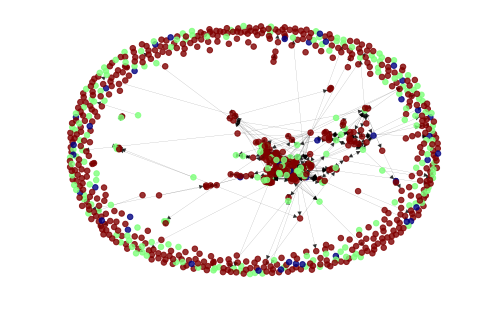

<Figure size 2880x2880 with 0 Axes>

In [ ]:

options = {
    'node_color' : color_node, # a list that contains the community id for the nodes we want to plot
    'node_size' : 30 , 
    'cmap' : plt.get_cmap("jet"),
    'node_shape' : 'o', 
    "width" : 0.1, 
    "font_size" : 15,
    "alpha" : 0.8   
}
nx.draw(G_bigU,  **options)
plt.figure(figsize=(40,40))
plt.show()

We can see on the plot above and on the characteristic on the *big_U network* that the main users are not connected a lot between each other and it does not seem to be any particular structure between fake or real sources.



In [ ]:
### We set G_u and G_main_user_und as the undirected versions of G and G_bigU

G_u = G.to_undirected()
G_main_user_und = G_bigU.to_undirected()

We can also have a look to the connected part of the network. Indeed we can observe that we have many nodes about 250 nodes that are not connected with the main group. We will need to remove some of these in order to apply some community detection methods. 

In [ ]:
connected_comp =  list(nx.connected_component_subgraphs(G_u))
l_con = []
for i in connected_comp:
    l_con.append(len(i))
print(l_con)

[23618, 2, 2, 2, 2, 4, 2, 3, 3, 2, 2, 2, 2, 2, 4, 3, 3, 2, 3, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2]


In [ ]:
G_connected = connected_comp[0]
nx.info(G_connected)

'Name: \nType: Graph\nNumber of nodes: 23618\nNumber of edges: 408675\nAverage degree:  34.6071'

## Node-Centric Metrics

We compute here some node-centric metrics and compare the results according to the different type of users ( fake or real sources, main fake sources or main real sources).
The idea is then to create a matrix containing for each news an aggregation of the scores of each users who shared the news and this for all the metrics. 

We compute some centrality metrics, the page_rank algorithm and the HITS algorithm. 

The degree centrality metric all give the same kind of results :
* the *small users* get really small score which appears to be logical, since we can imagine that if they don't share a lot they are not followed a lot and they don't follow a lot ( they are not really active on the network) 
* concerning the more important users we can observe clearly that the fake sources have much bigger results.

We also computed the closeness, betweenness and eigenvector centrality scores but none of them was relevant. We present here only eigenvector centrality results because the two others were really long to run.

The pageRank algorithm produce the same kind of results than the degree centrality scores.

We also computed the HITS algorithm knowing that it is not for this kind of analysis that it was build for, but because we have some interesting results we decided to keep them.

In [ ]:
centrality =  nx.degree_centrality(G)

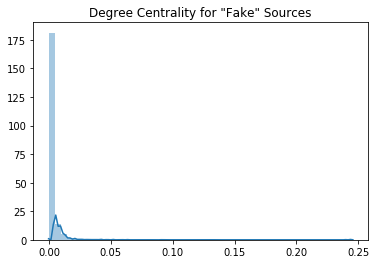

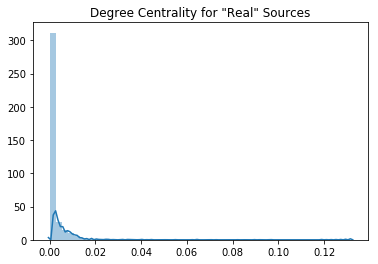

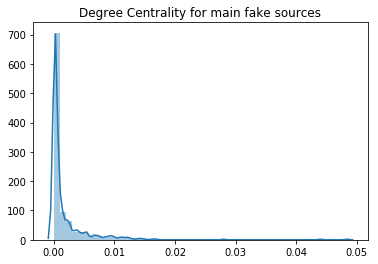

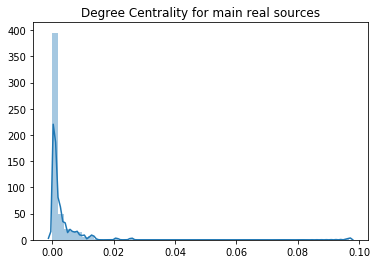

In [ ]:
real_cd = []
fake_cd = []
main_fake_cd =[]
main_real_cd =[]
for x in real_source:
    real_cd.append(centrality[x])
for x in fake_source:
    fake_cd.append(centrality[x])
for x in main_fake:
    main_fake_cd.append(centrality[x])
for x in main_real:
    main_real_cd.append(centrality[x])
    
sns.distplot(fake_cd)
plt.title('Degree Centrality for "Fake" Sources')
plt.show()


sns.distplot(real_cd)
plt.title('Degree Centrality for "Real" Sources')
plt.show()


sns.distplot(main_fake_cd)
plt.title('Degree Centrality for main fake sources')
plt.show()

sns.distplot(main_real_cd)
plt.title('Degree Centrality for main real sources')
plt.show()

In [ ]:
in_centrality = nx.in_degree_centrality(G)


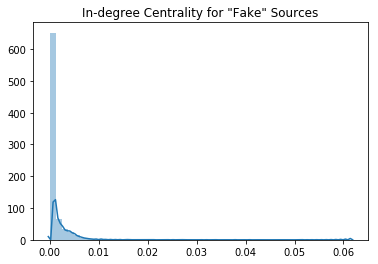

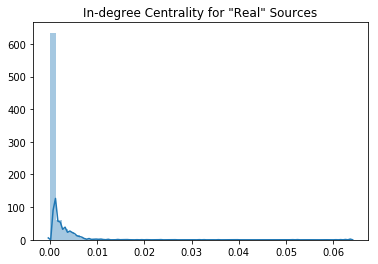

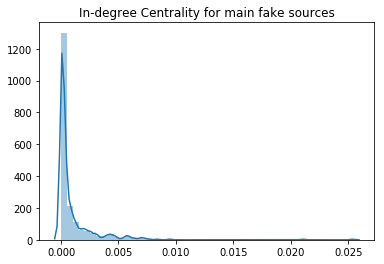

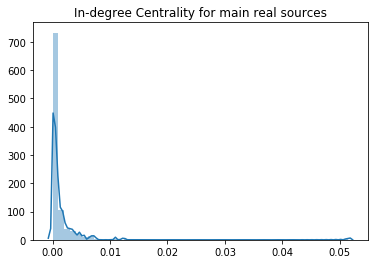

In [ ]:
real_in_cd = []
fake_in_cd = []
main_fake_incd = []
main_real_incd = []

for x in real_source:
    real_in_cd.append(in_centrality[x])
for x in fake_source:
    fake_in_cd.append(in_centrality[x])
for x in main_fake:
    main_fake_incd.append(in_centrality[x])
for x in main_real:
    main_real_incd.append(in_centrality[x])
    
    
sns.distplot(fake_in_cd)
plt.title('In-degree Centrality for "Fake" Sources')
plt.show()

sns.distplot(real_in_cd)
plt.title('In-degree Centrality for "Real" Sources')
plt.show()

sns.distplot(main_fake_incd)
plt.title('In-degree Centrality for main fake sources')
plt.show()

sns.distplot(main_real_incd)
plt.title('In-degree Centrality for main real sources')
plt.show()

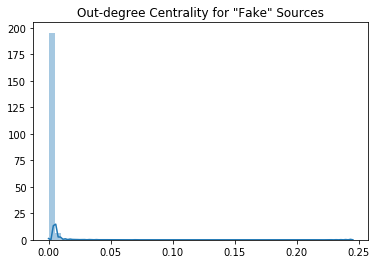

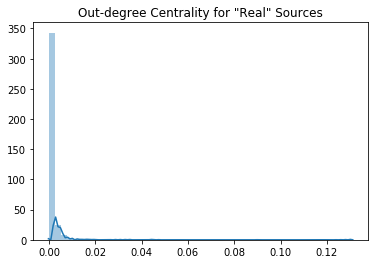

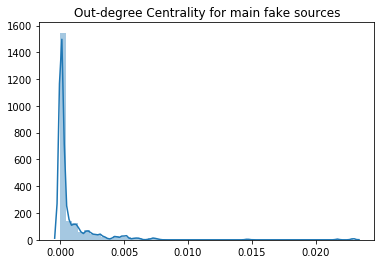

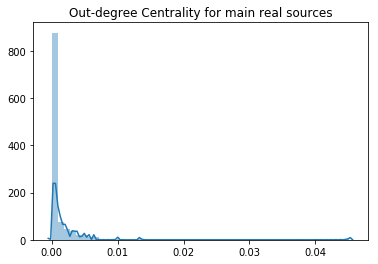

In [ ]:
out_centrality = nx.out_degree_centrality(G)

real_out_cd = []
fake_out_cd = []
main_fake_outcd = []
main_real_outcd = []

for x in real_source:
    real_out_cd.append(out_centrality[x])
for x in fake_source:
    fake_out_cd.append(out_centrality[x])
for x in main_fake:
    main_fake_outcd.append(out_centrality[x])
for x in main_real:
    main_real_outcd.append(out_centrality[x])
    
sns.distplot(fake_out_cd)
plt.title('Out-degree Centrality for "Fake" Sources')
plt.show()


sns.distplot(real_out_cd)
plt.title('Out-degree Centrality for "Real" Sources')
plt.show()


sns.distplot(main_fake_outcd)
plt.title('Out-degree Centrality for main fake sources')
plt.show()

sns.distplot(main_real_outcd)
plt.title('Out-degree Centrality for main real sources')
plt.show()

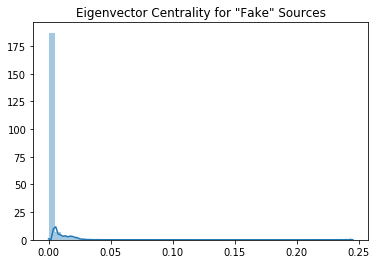

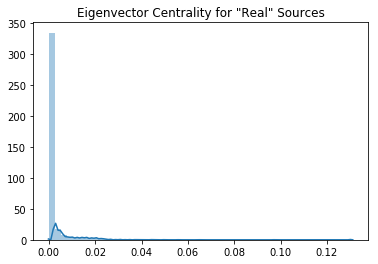

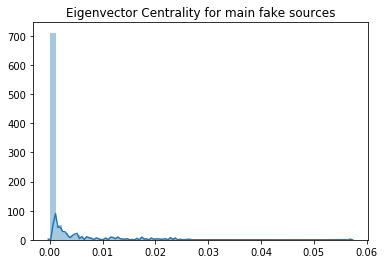

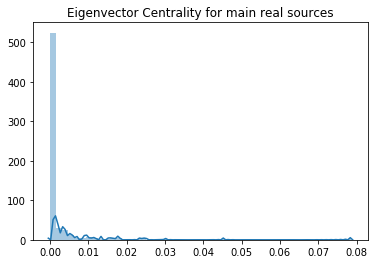

In [ ]:
eig_centrality = nx.eigenvector_centrality(G)

real_eig_cd = []
fake_eig_cd = []
main_fake_eig = []
main_real_eig = []

for x in real_source:
    real_out_cd.append(eig_centrality[x])
for x in fake_source:
    fake_out_cd.append(eig_centrality[x])
for x in main_fake:
    main_fake_outcd.append(eig_centrality[x])
for x in main_real:
    main_real_outcd.append(eig_centrality[x])
    
sns.distplot(fake_out_cd)
plt.title('Eigenvector Centrality for "Fake" Sources')
plt.show()


sns.distplot(real_out_cd)
plt.title('Eigenvector Centrality for "Real" Sources')
plt.show()


sns.distplot(main_fake_outcd)
plt.title('Eigenvector Centrality for main fake sources')
plt.show()

sns.distplot(main_real_outcd)
plt.title('Eigenvector Centrality for main real sources')
plt.show()

In [ ]:
page_rank = nx.pagerank(G)

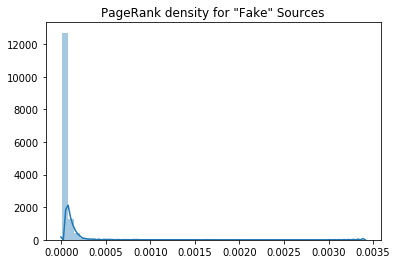

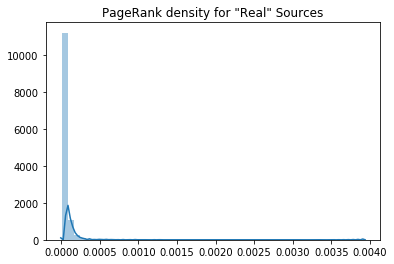

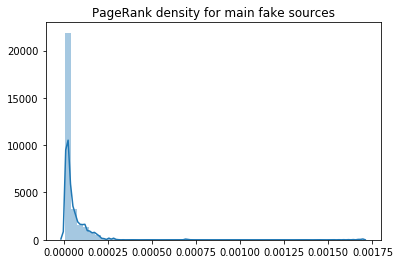

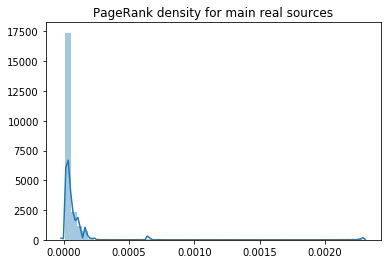

In [ ]:
real_pgr = []
fake_pgr= []
main_fake_pgr = []
main_real_pgr = []

for x in real_source:
    real_pgr.append(page_rank[x])
for x in fake_source:
    fake_pgr.append(page_rank[x])
for x in main_fake:
    main_fake_pgr.append(page_rank[x])
for x in main_real:
    main_real_pgr.append(page_rank[x])
    
sns.distplot(fake_pgr)
plt.title('PageRank density for "Fake" Sources')
plt.show()


sns.distplot(real_pgr)
plt.title('PageRank density for "Real" Sources')
plt.show()

sns.distplot(main_fake_pgr)
plt.title('PageRank density for main fake sources')
plt.show()

sns.distplot(main_real_pgr)
plt.title('PageRank density for main real sources')
plt.show()



In [ ]:
metrics_user =[centrality, in_centrality, out_centrality, page_rank]
d={}
for k in centrality.keys():
    d[k] = tuple(d[k] for d in metrics_user)
metrics_user=pd.DataFrame.from_dict(d,orient='index',columns=['degree_centrality','in_degree_centrality',
                                                       'out_degree_centrality', 'page_rank'])
metrics_user.index.rename('user')

Int64Index([  507,     1,  1589,  5307, 11421, 13267, 20571,  1205,     2,
             2631,
            ...
            23810, 23811, 23812, 23816, 23824, 23832, 23834, 23839, 23862,
            23864],
           dtype='int64', name='user', length=23865)

In [ ]:
metrics_user_news = pd.merge(metrics_user,news_users.set_index('user'), left_index=True, right_index=True)
metrics_user_news.index.name= 'user'
metrics_news = metrics_user_news.groupby('news').agg(['sum','mean','max','min'])
metrics_news = metrics_news.drop(columns=[('times', 'mean'),('times', 'max'),('times', 'min')])
#metrics_news.to_csv('metrics_news.csv',index=False)

In [ ]:
metrics_news.head(10)

degree_centrality                      ...  page_rank           times
                   sum      mean       max  ...        max       min   sum
news                                        ...                           
1             0.231730  0.006621  0.082006  ...   0.001263  0.000008    36
2             0.097259  0.002069  0.011272  ...   0.000345  0.000008    47
3             0.092063  0.002877  0.022503  ...   0.000290  0.000008    32
4             0.024053  0.001266  0.007082  ...   0.000156  0.000008    19
5             0.012362  0.001766  0.009596  ...   0.000113  0.000008     7
6             0.075218  0.001075  0.010560  ...   0.000162  0.000008    73
7             0.019569  0.001398  0.009973  ...   0.000206  0.000008    14
8             0.549447  0.002234  0.076559  ...   0.000306  0.000008   257
9             0.549447  0.002234  0.076559  ...   0.000306  0.000008   257
10            0.038552  0.001483  0.011230  ...   0.000161  0.000008    26

[10 rows x 17 columns]

We finally build our metrics matrix with for each news the degree centrality and the pagerank scores. We calculated for each news the sum, the mean, the max and the min of the metrics on the users who shared the news. We also added the number of time the news was shared.

## Communities detection

We then tried to apply some community detection algorithms to our graph in order to identify some comunities with the hope that they will be relevant for our classification. The idea would be to assign to each category a credibility scores according to its users. We tried 3 algorithms :

* the Louvain method
* the Fluid communities algorithm
* the Percolation method

We tried also the Girvan-Newman method but the results were really not relevant (a big community with almost everyone and a lot lot of really small ones) and it took a really long time to compute, so we removed it from the report.  

The Louvain algorithm is one of the most efficient community detection algorithm, it is based on a iterative maximisation of the modularity score which is a measure of the density of edges inside a community compared to the one outside. We present below the results obtained with this method:

In [ ]:
partition = community.best_partition(G_u, random_state=1234)



In [ ]:
v = defaultdict(list)

for key, value in sorted(partition.items()):
    v[value].append(key)


In [ ]:
nb_fake = []
nb_real = []
nb_fake_main = []
nb_real_main = []
nb_small = []

nb_test = []

l = []
N=0
for i in v.keys():
    l.append(len(v[i]))
    nb_fake.append(0)
    nb_real.append(0)
    nb_fake_main.append(0)
    nb_real_main.append(0)
    nb_test.append(0)
    nb_small.append(0)
    for j in v[i]:
        if G.nodes[j]['fake_source_level']==0 :
            nb_real[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_real_main[N] +=1
        elif G.nodes[j]['fake_source_level']==1 :
            nb_fake[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_fake_main[N] +=1
        elif  G.nodes[j]['fake_source_level']==-1:
            nb_test[N] +=1
        if  G.nodes[j]['main_user']==0:
            nb_small[N] +=1
    N += 1

df_louvain = pd.DataFrame({'length': l, 
                  'nb_fake' : nb_fake,
                  'nb_real' : nb_real,
                  'nb_main_fake': nb_fake_main,
                  'nb_main_real': nb_real_main,
                  'nb_small_users': nb_small,
                  'unknown credibility' : nb_test},
                          columns =['length','nb_fake','nb_real','nb_main_fake','nb_main_real','nb_small_users','unknown credibility'])
df_louvain

,length,nb_fake,nb_real,nb_main_fake,nb_main_real,nb_small_users,unknown credibility
0,5004,3068,1551,129,52,4814,385
1,12365,7451,3949,293,116,11935,965
2,5435,3283,1720,134,45,5246,432
3,4,4,0,0,0,4,0
4,272,160,88,8,1,263,24
5,122,74,34,4,1,117,14
6,9,8,1,1,0,8,0
7,2,1,1,0,0,2,0
8,2,1,1,0,0,2,0
9,8,4,3,0,0,8,1


In [ ]:
print('There are %1.f communities with more than 10 users ' %df_louvain.length[df_louvain["length"]>=10].count())
print('There are %1.f communities with less than 5 users ' %df_louvain.length[df_louvain["length"]<5].count())

There are 12 communities with more than 10 users 
There are 189 communities with less than 5 users 


In [ ]:
### Communities with more than 10 nodes

df_louvain[df_louvain["length"]>=10]

,length,nb_fake,nb_real,nb_main_fake,nb_main_real,nb_small_users,unknown credibility
0,5004,3068,1551,129,52,4814,385
1,12365,7451,3949,293,116,11935,965
2,5435,3283,1720,134,45,5246,432
4,272,160,88,8,1,263,24
5,122,74,34,4,1,117,14
10,33,22,8,3,0,30,3
15,31,18,8,1,0,30,5
27,10,5,5,0,0,10,0
36,21,16,4,1,0,20,1
39,14,5,7,0,0,14,2


In [ ]:
#Proportion of users in each category for the communities with more than 10 nodes

df_louvain[['length','nb_fake','nb_real','nb_main_fake','nb_main_real']][df_louvain["length"]>=10].div(df_louvain.length[df_louvain["length"]>=10], axis=0)

,length,nb_fake,nb_real,nb_main_fake,nb_main_real
0,1.0,0.613110,0.309952,0.025779,0.010392
1,1.0,0.602588,0.319369,0.023696,0.009381
2,1.0,0.604048,0.316467,0.024655,0.008280
4,1.0,0.588235,0.323529,0.029412,0.003676
5,1.0,0.606557,0.278689,0.032787,0.008197
10,1.0,0.666667,0.242424,0.090909,0.000000
15,1.0,0.580645,0.258065,0.032258,0.000000
27,1.0,0.500000,0.500000,0.000000,0.000000
36,1.0,0.761905,0.190476,0.047619,0.000000
39,1.0,0.357143,0.500000,0.000000,0.000000


The Louvain algorithm computed on the full undirected version of the graph produces the 214 communities summurized in the dataframe above. For each community we have its length, the number of *fake* and *real* sources, the number  of *fake* and *real* sources among the most important users, the number of *small* users and the number of user for whom we don't have any information about their credibility.

There are only 12 communities with more than 10 people and 189 have strictly less than 5 people. So firstly for all these tiny communities we cannot objectively give them a credibility score, even more when one remarks that a lot of this small communities include people for who we don't know nothing. But even when we look at the biggest communities we can observe in all of them approximatively the same proportion for each category we defined. 

So it appears complicated to fix a credibility score for these communities. We then tried (below) to compute the Louvain algorithm on the biggest connected graph but we obtained kind of the same results.

In [ ]:
partition2 = community.best_partition(G_connected)
v = defaultdict(list)

for key, value in sorted(partition2.items()):
    v[value].append(key)
    
nb_fake = []
nb_real = []
nb_fake_main = []
nb_real_main = []
nb_small = []

nb_test = []

l = []
N=0
for i in v.keys():
    l.append(len(v[i]))
    nb_fake.append(0)
    nb_real.append(0)
    nb_fake_main.append(0)
    nb_real_main.append(0)
    nb_test.append(0)
    nb_small.append(0)
    for j in v[i]:
        if G.nodes[j]['fake_source_level']==0 :
            nb_real[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_real_main[N] +=1
        elif G.nodes[j]['fake_source_level']==1 :
            nb_fake[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_fake_main[N] +=1
        elif  G.nodes[j]['fake_source_level']==-1:
            nb_test[N] +=1
        if  G.nodes[j]['main_user']==0:
            nb_small[N] +=1
    N += 1

df_louvain2 = pd.DataFrame({'length ': l, 
                  'nb_fake' : nb_fake,
                  'nb_real' : nb_real,
                  'nb_main_fake': nb_fake_main,
                  'nb_main_real': nb_real_main,
                  'nb_small_users': nb_small,
                  'unknown credibility' : nb_test} )
df_louvain2

,length,nb_fake,nb_real,nb_main_fake,nb_main_real,nb_small_users,unknown credibility
0,3148,1913,1006,87,27,3028,229
1,12049,7248,3857,293,114,11621,944
2,4723,2877,1467,112,39,4564,379
3,2692,1654,825,60,30,2597,213
4,589,342,196,14,4,571,51
5,156,96,44,4,2,150,16
6,9,8,1,1,0,8,0
7,2,1,1,0,0,2,0
8,2,1,1,0,0,2,0
9,8,4,3,0,0,8,1


We then tried the Fluid community algorithm which works on the same principle than the Kmeans. We set the number of communities to be found and the algorithm should converge to the best communities. To select the  best number of communities we try it for several values and compute the coverage score, but it appears that 2 communities correspond to the best fit. After analyzing these two communities we decided to watch also the communities we obtained when we set their number to 6.

However the results we get are still not like expected, we cannot really identify *fake or real communities*.

In [ ]:
from networkx.algorithms import community

b=community.asyn_fluidc(G_connected, 2)
a=community.coverage(G_connected,list(b))
best = 2
for k in [4,6,8,10]:
    fluid=community.asyn_fluidc(G_connected, k)
    c = community.coverage(G_connected, list(fluid))
    print(k,c)
    if c>a:
        a=community.coverage(G_connected,list(fluid))
        best=k
        
print(best)



4 0.8481384963601885
6 0.8171921453477702
8 0.766266593258702
10 0.7377182357619135
2


In [ ]:
Fcommunities = list(community.asyn_fluidc(G_connected, 2))
for i in Fcommunities:
    print(len(i))

13484
10134


In [ ]:
nb_fake = []
nb_real = []
nb_fake_main = []
nb_real_main = []
nb_small = []

nb_test = []

l = []
N=0
for i in Fcommunities:
    l.append(len(i))
    nb_fake.append(0)
    nb_real.append(0)
    nb_fake_main.append(0)
    nb_real_main.append(0)
    nb_test.append(0)
    nb_small.append(0)
    for j in i:
        if G.nodes[j]['fake_source_level']==0 :
            nb_real[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_real_main[N] +=1
        elif G.nodes[j]['fake_source_level']==1 :
            nb_fake[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_fake_main[N] +=1
        elif  G.nodes[j]['fake_source_level']==-1:
            nb_test[N] +=1
        if  G.nodes[j]['main_user']==0:
            nb_small[N] +=1
    N += 1



df = pd.DataFrame({'length ': l, 
                  'nb_fake' : nb_fake,
                  'nb_real' : nb_real,
                  'nb_main_fake': nb_fake_main,
                  'nb_main_real': nb_real_main,
                  'nb_small_users': nb_small,
                  'unknown credibility' : nb_test} )
df

,length,nb_fake,nb_real,nb_main_fake,nb_main_real,nb_small_users,unknown credibility
0,13484,8097,4313,328,124,13012,1074
1,10134,6186,3160,249,94,9770,788


In [ ]:
Fcommunities = list(community.asyn_fluidc(G_connected, 6))


In [ ]:
for i in Fcommunities:
    print(len(i))

2428
3630
5925
2797
4402
4436


In [ ]:
nb_fake = []
nb_real = []
nb_fake_main = []
nb_real_main = []
nb_small = []

nb_test = []

l = []
N=0
for i in Fcommunities:
    l.append(len(i))
    nb_fake.append(0)
    nb_real.append(0)
    nb_fake_main.append(0)
    nb_real_main.append(0)
    nb_test.append(0)
    nb_small.append(0)
    for j in i:
        if G.nodes[j]['fake_source_level']==0 :
            nb_real[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_real_main[N] +=1
        elif G.nodes[j]['fake_source_level']==1 :
            nb_fake[N] += 1
            if G.nodes[j]['main_user']==1:
                nb_fake_main[N] +=1
        elif  G.nodes[j]['fake_source_level']==-1:
            nb_test[N] +=1
        if  G.nodes[j]['main_user']==0:
            nb_small[N] +=1
    N += 1



df_fcommu = pd.DataFrame({'length ': l, 
                  'nb_fake' : nb_fake,
                  'nb_real' : nb_real,
                  'nb_main_fake': nb_fake_main,
                  'nb_main_real': nb_real_main,
                  'nb_small_users': nb_small,
                  'unknown credibility' : nb_test} )
df_fcommu

,length,nb_fake,nb_real,nb_main_fake,nb_main_real,nb_small_users,unknown credibility
0,2428,1475,760,57,21,2343,193
1,3630,2170,1154,76,38,3508,306
2,5925,3591,1869,154,60,5701,465
3,2797,1700,878,79,20,2696,219
4,4402,2660,1403,107,41,4246,339
5,4436,2687,1409,104,38,4288,340


We finally tried a Clique Percolation method, which identify all the clique of k nodes (k to be set by the user) , draw a graph of clique setting an edge if two cliques have k-1 common nodes, and define as a community all the nodes included in a connected component of this new graph. The results were here again not really relevant (4695 communities) so we decided to not include metrics about the communities.

In [ ]:
Pcommunities = list(community.k_clique_communities(G_u, 5, cliques=None))

In [ ]:
print(len(Pcommunities))
l=[]
for i in Pcommunities:
    l.append(len(i))

4659
